In [22]:
import sys
!{sys.executable} -m pip install ultralytics opencv-python matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import ultralytics
import os
import shutil
import random
import yaml
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

ultralytics.checks()

Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
Setup complete ✅ (12 CPUs, 30.9 GB RAM, 197.4/227.8 GB disk)


In [24]:
# Import class names from existing YAML file
def load_class_names_from_yaml(yaml_path):
    """Load class names from existing data.yaml file."""
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        class_names = data.get('names', [])
        if isinstance(class_names, dict):
            # If names is a dictionary (class_id: class_name), convert to list
            class_names = [class_names[i] for i in sorted(class_names.keys())]
        elif isinstance(class_names, list):
            # If names is already a list, use as is
            pass
        else:
            raise ValueError("Class names in YAML should be either a list or dictionary")

        # Validate class names
        if not class_names:
            raise ValueError("No class names found in YAML file")

        # Check for valid class names (no empty strings)
        class_names = [str(name).strip() for name in class_names if str(name).strip()]

        print(f"Loaded {len(class_names)} class names from {yaml_path}")
        print(f"Classes: {class_names}")
        return class_names
    else:
        raise FileNotFoundError(f"YAML file not found: {yaml_path}")

def validate_yaml_structure(yaml_path):
    """Validate the structure of YAML file for YOLOv8 compatibility."""
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        required_keys = ['names']
        optional_keys = ['path', 'train', 'val', 'test', 'nc']

        missing_keys = [key for key in required_keys if key not in data]
        if missing_keys:
            print(f"Warning: Missing required keys in YAML: {missing_keys}")

        present_keys = [key for key in optional_keys if key in data]
        print(f"Present optional keys: {present_keys}")

        # Validate nc matches number of names
        if 'nc' in data and 'names' in data:
            names = data['names']
            if isinstance(names, list):
                expected_nc = len(names)
            elif isinstance(names, dict):
                expected_nc = len(names)
            else:
                expected_nc = 0

            if data['nc'] != expected_nc:
                print(f"Warning: 'nc' ({data['nc']}) doesn't match number of class names ({expected_nc})")

        return True
    except Exception as e:
        print(f"Error validating YAML: {e}")
        return False

# Dataset configuration
DATASET_PATH = "data/YOLO-Bulk"  # dataset path
OUTPUT_PATH = "yolo_dataset_split"
YAML_CONFIG_PATH = "data/YOLO-Bulk/data.yaml"  # Path to data.yaml 

# Load class names from YAML file
try:
    # First validate the YAML structure
    if os.path.exists(YAML_CONFIG_PATH):
        print("Validating YAML file structure...")
        validate_yaml_structure(YAML_CONFIG_PATH)

    CLASS_NAMES = load_class_names_from_yaml(YAML_CONFIG_PATH)
except FileNotFoundError:
    print(f"Error: {YAML_CONFIG_PATH} not found.")
    os.abort()
except Exception as e:
    print(f"Error loading YAML: {e}")
    os.abort()

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Training configuration
MODEL_SIZE = "yolov8n.pt"  # other yolov8 options exist
EPOCHS = 500
IMAGE_SIZE = 640
BATCH_SIZE = 16

print(f"Train: {TRAIN_RATIO*100}%, Val: {VAL_RATIO*100}%, Test: {TEST_RATIO*100}%")
print(f"Number of classes: {len(CLASS_NAMES)}")

Validating YAML file structure...
Present optional keys: ['nc']
Loaded 26 class names from data/YOLO-Bulk/data.yaml
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Train: 70.0%, Val: 15.0%, Test: 15.0%
Number of classes: 26


In [25]:
def inspect_yaml_file(yaml_path):
    """Inspect and display the contents of a YAML configuration file."""
    if not os.path.exists(yaml_path):
        print(f"YAML file not found: {yaml_path}")
        return None

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    print("YAML File Contents:")
    print("=" * 50)
    for key, value in data.items():
        print(f"{key}: {value}")

    return data


# Inspect existing YAML file
print("Checking data.yaml...")
if os.path.exists(YAML_CONFIG_PATH):
    yaml_data = inspect_yaml_file(YAML_CONFIG_PATH)
    print("\nValidating YAML structure...")
    validate_yaml_structure(YAML_CONFIG_PATH)
else:
    print(f"YAML file '{YAML_CONFIG_PATH}' not found.")
    print("Expected location: /data/YOLO-Bulk/data.yaml")

Checking data.yaml...
YAML File Contents:
nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
roboflow: {'workspace': 'david-lee-d0rhs', 'project': 'american-sign-language-letters', 'version': 1, 'license': 'Public Domain', 'url': 'https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1'}

Validating YAML structure...
Present optional keys: ['nc']


In [26]:
def analyze_dataset(dataset_path):
    """Analyze the original dataset structure and content."""
    print("Dataset Analysis:")
    print("=" * 50)

    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        print("Error: Expected 'images' and 'labels' folders in dataset path")
        return False

    # Count files
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    label_files = [f for f in os.listdir(labels_path) if f.lower().endswith('.txt')]

    print(f"Images found: {len(image_files)}")
    print(f"Labels found: {len(label_files)}")

    # Check for matching files
    image_names = {os.path.splitext(f)[0] for f in image_files}
    label_names = {os.path.splitext(f)[0] for f in label_files}

    matched = len(image_names.intersection(label_names))
    unmatched_images = len(image_names - label_names)
    unmatched_labels = len(label_names - image_names)

    print(f"Matched image-label pairs: {matched}")
    print(f"Images without labels: {unmatched_images}")
    print(f"Labels without images: {unmatched_labels}")

    return True

# Analyze the dataset
analyze_dataset(DATASET_PATH)

Dataset Analysis:
Images found: 1728
Labels found: 1728
Matched image-label pairs: 1728
Images without labels: 0
Labels without images: 0


True

In [27]:
def create_directory_structure(output_path):
    """Create the directory structure for train/val/test splits."""
    splits = ['train', 'val', 'test']

    for split in splits:
        os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

    print(f"Created directory structure at: {output_path}")

def get_matched_files(dataset_path):
    """Get list of files that have both image and label."""
    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        raise FileNotFoundError(f"Images or labels directory not found in {dataset_path}")

    # Get all image files with multiple extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    image_files = []
    for ext in image_extensions:
        image_files.extend([f for f in os.listdir(images_path) if f.lower().endswith(ext)])

    print(f"Found {len(image_files)} image files")

    # Filter to only those with corresponding labels
    matched_files = []
    missing_labels = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        img_path = os.path.join(images_path, img_file)
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            matched_files.append((img_path, label_path, base_name, img_file))
        else:
            missing_labels.append(img_file)

    if missing_labels:
        print(f"Warning: {len(missing_labels)} images don't have corresponding labels")
        if len(missing_labels) <= 10:
            print(f"Missing labels for: {missing_labels}")
        else:
            print(f"First 10 missing labels: {missing_labels[:10]}")

    print(f"Matched image-label pairs: {len(matched_files)}")
    return matched_files

def split_dataset(matched_files, train_ratio, val_ratio, test_ratio):
    """Split the dataset into train/val/test sets."""
    random.shuffle(matched_files)

    total_files = len(matched_files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    train_files = matched_files[:train_count]
    val_files = matched_files[train_count:train_count + val_count]
    test_files = matched_files[train_count + val_count:]

    print(f"Split summary:")
    print(f"Train: {len(train_files)} files ({len(train_files)/total_files*100:.1f}%)")
    print(f"Val: {len(val_files)} files ({len(val_files)/total_files*100:.1f}%)")
    print(f"Test: {len(test_files)} files ({len(test_files)/total_files*100:.1f}%)")

    return train_files, val_files, test_files

def copy_files(file_list, output_path, split_name):
    """Copy files to the appropriate split directory."""
    for img_path, label_path, base_name, img_filename in file_list:
        # Copy image (preserve original extension)
        img_ext = os.path.splitext(img_filename)[1]
        new_img_path = os.path.join(output_path, split_name, 'images', base_name + img_ext)
        shutil.copy2(img_path, new_img_path)

        # Copy label
        new_label_path = os.path.join(output_path, split_name, 'labels', base_name + '.txt')
        shutil.copy2(label_path, new_label_path)

    print(f"Copied {len(file_list)} files to {split_name} split")

In [28]:
create_directory_structure(OUTPUT_PATH)

matched_files = get_matched_files(DATASET_PATH)

if len(matched_files) == 0:
    print("Error: No matched image-label pairs found!")
    print("Please check that:")
    print("1. Images are in /data/YOLO-Bulk/images/")
    print("2. Labels are in /data/YOLO-Bulk/labels/")
    print("3. Image and label files have matching names (except extensions)")
else:
    print(f"Ready to split {len(matched_files)} matched image-label pairs")

    # Split the dataset
    train_files, val_files, test_files = split_dataset(
        matched_files, TRAIN_RATIO, VAL_RATIO, TEST_RATIO
    )

    # Copy files to respective directories
    copy_files(train_files, OUTPUT_PATH, 'train')
    copy_files(val_files, OUTPUT_PATH, 'val')
    copy_files(test_files, OUTPUT_PATH, 'test')

    print("\n" + "="*50)
    print("DATASET SPLIT COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"Original dataset: {DATASET_PATH}")
    print(f"Split dataset: {OUTPUT_PATH}")
    print(f"Total files processed: {len(matched_files)}")

Created directory structure at: yolo_dataset_split
Found 1728 image files
Matched image-label pairs: 1728
Ready to split 1728 matched image-label pairs
Split summary:
Train: 1209 files (70.0%)
Val: 259 files (15.0%)
Test: 260 files (15.0%)
Copied 1209 files to train split
Copied 259 files to val split
Copied 260 files to test split

DATASET SPLIT COMPLETED SUCCESSFULLY!
Original dataset: data/YOLO-Bulk
Split dataset: yolo_dataset_split
Total files processed: 1728


In [29]:
def create_yaml_config(output_path, class_names, base_yaml_path=None):
    """Create YAML configuration file for YOLOv8."""
    # Start with base configuration if provided
    config = {}
    if base_yaml_path and os.path.exists(base_yaml_path):
        with open(base_yaml_path, 'r') as f:
            config = yaml.safe_load(f) or {}
        print(f"Using base configuration from: {base_yaml_path}")

    # Update with new paths and class information
    config.update({
        'path': os.path.abspath(output_path),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    })

    yaml_path = os.path.join(output_path, 'dataset.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f)

    print(f"Created YAML config at: {yaml_path}")
    return yaml_path

# Create YAML configuration, optionally using existing YAML as base
yaml_config_path = create_yaml_config(OUTPUT_PATH, CLASS_NAMES, YAML_CONFIG_PATH if os.path.exists(YAML_CONFIG_PATH) else None)

# Display the config
with open(yaml_config_path, 'r') as f:
    print("\nDataset configuration:")
    print(f.read())

Using base configuration from: data/YOLO-Bulk/data.yaml
Created YAML config at: yolo_dataset_split/dataset.yaml

Dataset configuration:
names:
- A
- B
- C
- D
- E
- F
- G
- H
- I
- J
- K
- L
- M
- N
- O
- P
- Q
- R
- S
- T
- U
- V
- W
- X
- Y
- Z
nc: 26
path: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split
roboflow:
  license: Public Domain
  project: american-sign-language-letters
  url: https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1
  version: 1
  workspace: david-lee-d0rhs
test: test/images
train: train/images
val: val/images




Sample images from train set:


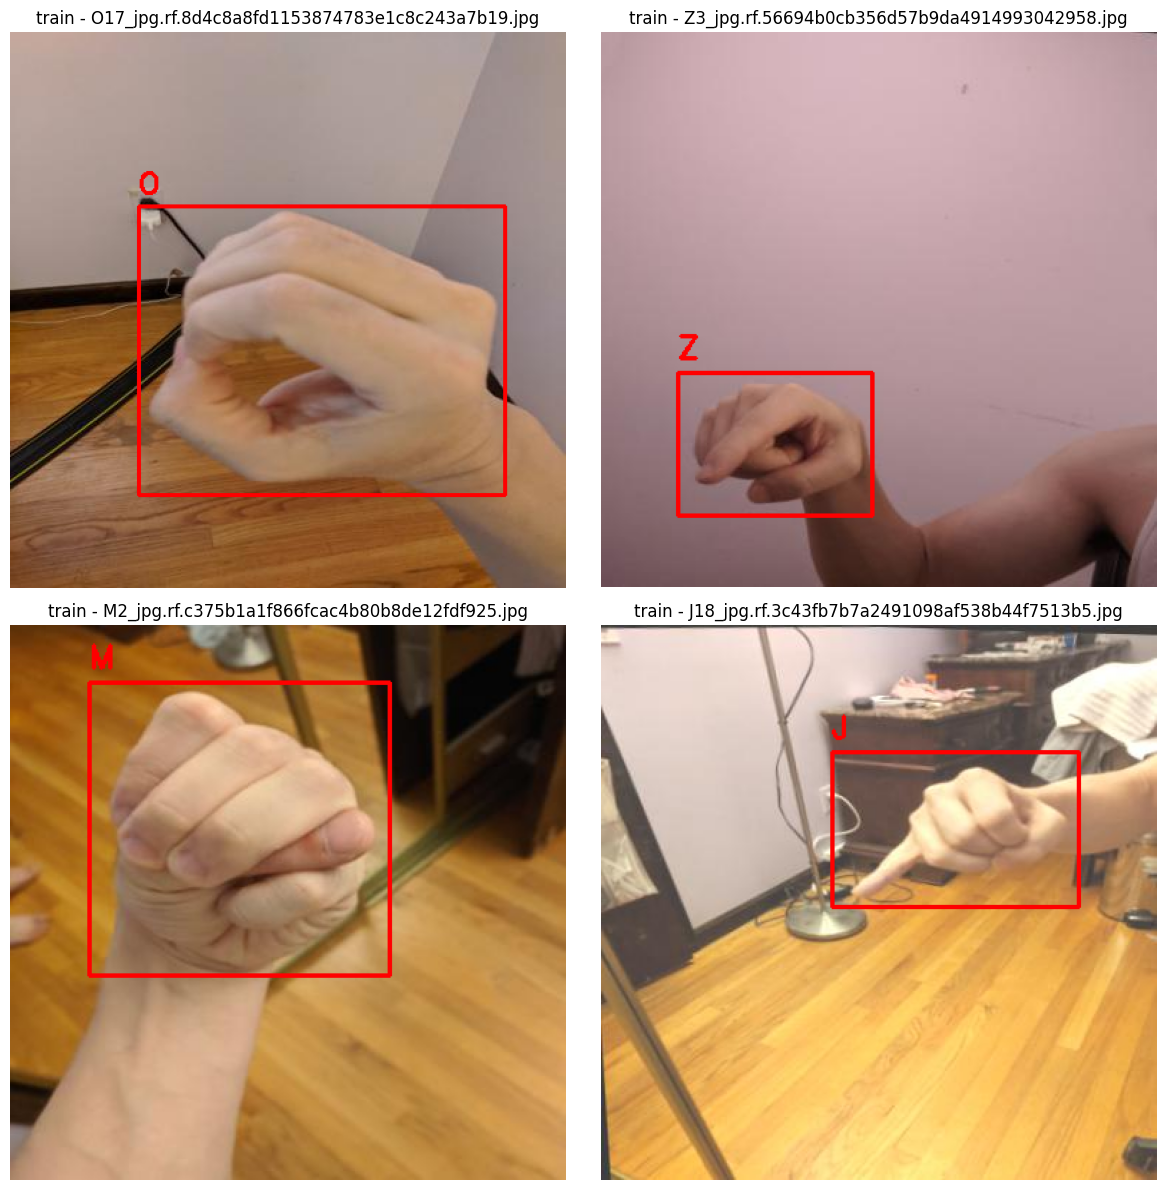


Sample images from val set:


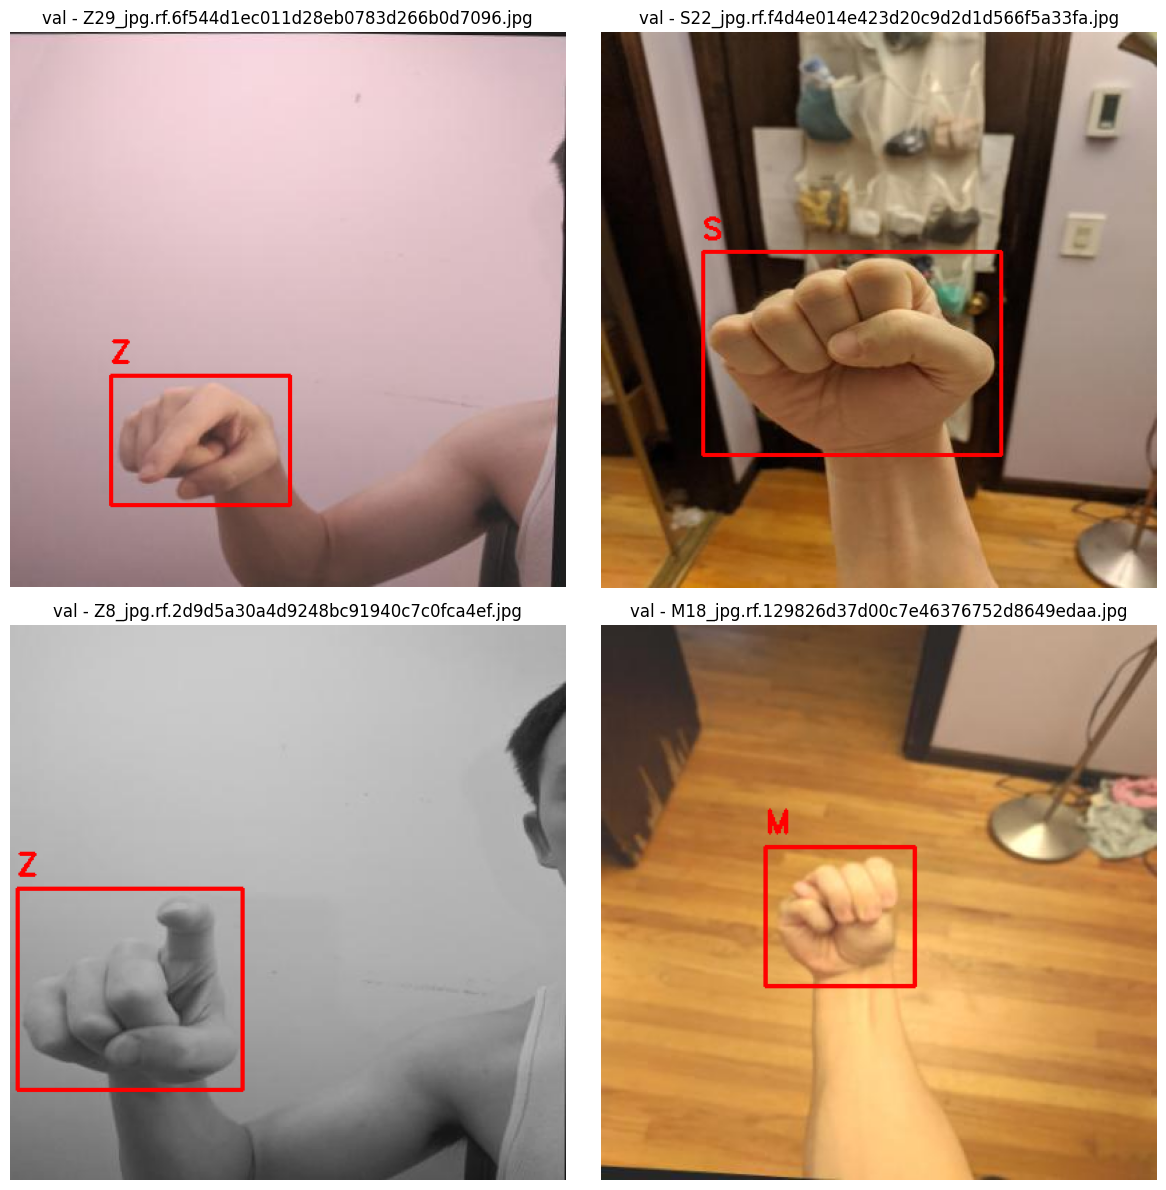


Sample images from test set:


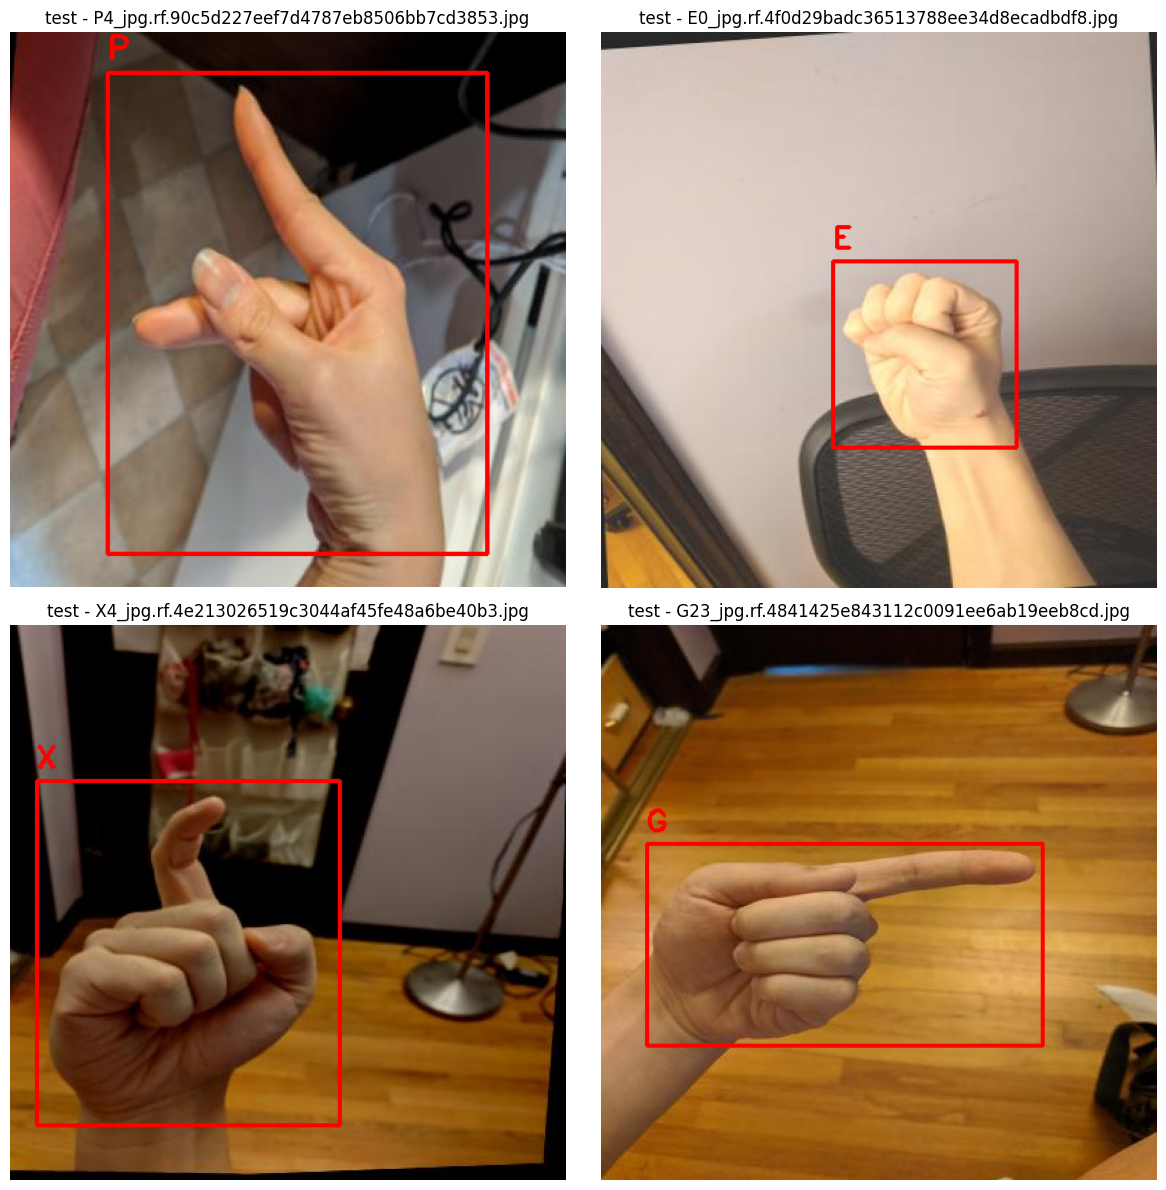

In [30]:
def visualize_samples(output_path, split='train', num_samples=4):
    """Visualize sample images with their annotations."""
    images_dir = os.path.join(output_path, split, 'images')
    labels_dir = os.path.join(output_path, split, 'labels')

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for idx, img_file in enumerate(sample_files):
        if idx >= 4:
            break

        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Load annotations
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, base_name + '.txt')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)

                    # Convert to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    # Draw bounding box
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

                    # Add class label
                    if int(class_id) < len(CLASS_NAMES):
                        label = CLASS_NAMES[int(class_id)]
                        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        axes[idx].imshow(image)
        axes[idx].set_title(f'{split} - {img_file}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from each split
for split in ['train', 'val', 'test']:
    print(f"\nSample images from {split} set:")
    visualize_samples(OUTPUT_PATH, split)

In [31]:
def train_yolo_model(yaml_config_path, model_size, epochs, image_size, batch_size):
    """Train YOLOv8 model."""
    print(f"Starting training with {model_size}")
    print(f"Configuration: epochs={epochs}, image_size={image_size}, batch_size={batch_size}")

    # Load model
    model = YOLO(model_size)

    # Train the model
    results = model.train(
        data=yaml_config_path,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        save=True,
        project='ASL-fingerspelling',
        name='asl-model',
        exist_ok=True, # overwrite
        patience=20,
        save_period=10
    )

    return model, results

# Start training
print("Initializing model training...")
model, training_results = train_yolo_model(
    yaml_config_path, MODEL_SIZE, EPOCHS, IMAGE_SIZE, BATCH_SIZE
)

print("Training completed!")

Initializing model training...
Starting training with yolov8n.pt
Configuration: epochs=500, image_size=640, batch_size=16
New https://pypi.org/project/ultralytics/8.3.169 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_split/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/train/labels.cache... 1694 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1694/1694 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 645.3±365.4 MB/s, size: 13.0 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels.cache... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:00<?, ?it/s]


Plotting labels to ASL-fingerspelling/asl-model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ASL-fingerspelling/asl-model
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      2.53G      1.035      4.346      1.466         36        640: 100%|██████████| 106/106 [00:10<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:01<00:00, 11.75it/s]

                   all        720        720     0.0372      0.134      0.033      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/500      2.53G     0.9822      3.792      1.404         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.47it/s]

                   all        720        720      0.302      0.323      0.192      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      2.53G      1.024      3.283      1.424         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.22it/s]

                   all        720        720      0.287      0.477      0.316      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/500      2.53G      1.075      3.035      1.433         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.35it/s]

                   all        720        720      0.343      0.483      0.372      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/500      2.53G      1.065      2.836       1.42         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.29it/s]

                   all        720        720      0.346      0.427      0.352      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/500      2.53G      1.017      2.593      1.372         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.65it/s]

                   all        720        720       0.49      0.609      0.549      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/500      2.53G     0.9941      2.386      1.356         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.80it/s]

                   all        720        720      0.655      0.685      0.728      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      8/500      2.53G     0.9831      2.258      1.337         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.79it/s]

                   all        720        720      0.664      0.681      0.751      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/500      2.53G     0.9623      2.116       1.32         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.59it/s]

                   all        720        720      0.709      0.711      0.814      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/500      2.53G     0.9213      1.962      1.275         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.80it/s]

                   all        720        720      0.739      0.736      0.817      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/500      2.53G     0.9405      1.909      1.298         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.85it/s]

                   all        720        720      0.739      0.799      0.874      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/500      2.53G     0.9239       1.81      1.293         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.91it/s]

                   all        720        720      0.753      0.814      0.885      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/500      2.53G     0.9122      1.767      1.281         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.90it/s]

                   all        720        720      0.828      0.781      0.892      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     14/500      2.53G     0.9018      1.721      1.273         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.46it/s]

                   all        720        720      0.818      0.836      0.898      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      2.53G     0.8952      1.595      1.262         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.86it/s]

                   all        720        720      0.793      0.727      0.839      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/500      2.53G     0.8896      1.588      1.256         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.90it/s]

                   all        720        720      0.789      0.859        0.9      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     17/500      2.53G     0.8708      1.532      1.242         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.93it/s]

                   all        720        720      0.858      0.848      0.941      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/500      2.53G     0.8614      1.457      1.239         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.96it/s]

                   all        720        720        0.9      0.931      0.971      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     19/500      2.53G      0.857      1.415      1.234         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.99it/s]

                   all        720        720      0.904      0.895      0.969      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/500      2.53G     0.8538      1.388      1.233         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.94it/s]

                   all        720        720      0.893      0.914      0.971      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     21/500      2.53G     0.8433       1.34      1.226         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.97it/s]

                   all        720        720      0.949      0.928      0.982      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/500      2.53G     0.8408      1.307      1.218         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.96it/s]

                   all        720        720      0.903      0.917      0.971      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/500      2.53G      0.836      1.279      1.219         39        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.00it/s]

                   all        720        720      0.937      0.939      0.984      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/500      2.53G     0.8452      1.246      1.215         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.01it/s]

                   all        720        720      0.905      0.909      0.961      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     25/500      2.53G      0.828      1.257      1.211         20        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.43it/s]

                   all        720        720      0.937      0.926      0.982      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      2.53G      0.831      1.227      1.218         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.63it/s]

                   all        720        720      0.953      0.949      0.986       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     27/500      2.53G     0.8113      1.183      1.206         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.98it/s]

                   all        720        720       0.92      0.926      0.967      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/500      2.53G     0.8155      1.164      1.209         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.05it/s]

                   all        720        720      0.921      0.942      0.982      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/500      2.53G     0.7964      1.156      1.188         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.07it/s]

                   all        720        720      0.946      0.958      0.986      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/500      2.53G     0.8071      1.142      1.197         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720      0.957      0.953      0.986       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     31/500      2.53G      0.802      1.133      1.197         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720      0.962      0.967      0.992      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     32/500      2.53G     0.7952      1.109      1.193         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.95it/s]

                   all        720        720      0.967      0.965       0.99      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     33/500      2.53G     0.7878      1.101      1.182         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.05it/s]

                   all        720        720      0.951      0.976      0.992      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     34/500      2.53G     0.7868      1.088      1.183         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.07it/s]

                   all        720        720       0.95      0.972      0.991      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     35/500      2.53G     0.7788      1.066      1.175         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.06it/s]

                   all        720        720      0.962      0.969      0.992      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/500      2.53G      0.791      1.079      1.182         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.42it/s]

                   all        720        720      0.963      0.973      0.993      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     37/500      2.53G     0.7558      1.018      1.162         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720      0.971      0.973      0.994      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     38/500      2.53G     0.7747      1.039      1.178         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.06it/s]

                   all        720        720      0.957      0.973      0.989      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     39/500      2.53G     0.7652     0.9834      1.158         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720       0.97      0.968      0.992      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     40/500      2.53G       0.77      1.026      1.169         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.07it/s]

                   all        720        720      0.978      0.987      0.993      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     41/500      2.53G     0.7661     0.9898      1.173         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.974      0.971      0.989      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     42/500      2.53G     0.7572     0.9582      1.162         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.07it/s]

                   all        720        720      0.982      0.972      0.994      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     43/500      2.53G     0.7668     0.9858      1.165         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.07it/s]

                   all        720        720      0.974      0.975      0.994      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     44/500      2.53G     0.7586      0.965      1.162         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.06it/s]

                   all        720        720      0.971      0.978      0.994      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     45/500      2.53G     0.7645     0.9696      1.166         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720       0.97      0.989      0.994      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     46/500      2.53G     0.7467     0.9316      1.154         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720      0.987      0.988      0.994       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     47/500      2.53G     0.7518     0.9259      1.157         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720      0.961      0.921      0.979      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     48/500      2.53G     0.7374     0.8993       1.14         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.978      0.988      0.994      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/500      2.53G     0.7407     0.9007      1.157         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.989      0.983      0.994      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     50/500      2.53G     0.7295     0.8799      1.153         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.977      0.988      0.994      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/500      2.53G     0.7386      0.886      1.146         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.952       0.97      0.991      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     52/500      2.53G     0.7406     0.8774      1.155         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.984      0.976      0.993      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     53/500      2.53G     0.7362     0.8906       1.15         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.982      0.993      0.994      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     54/500      2.53G     0.7278     0.8968      1.151         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.985      0.992      0.994      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/500      2.53G     0.7207     0.8752      1.142         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720       0.99      0.988      0.995      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     56/500      2.53G     0.7276     0.8656      1.132         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.974      0.992      0.995      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     57/500      2.53G     0.7148     0.8518      1.144         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.983       0.99      0.995      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     58/500      2.53G     0.7342     0.8696      1.159         23        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.06it/s]

                   all        720        720      0.985      0.986      0.994      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     59/500      2.53G     0.7021     0.8254      1.122         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.985      0.992      0.995      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     60/500      2.53G     0.7202     0.8493      1.132         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.981      0.984      0.993      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     61/500      2.53G     0.7242     0.8499      1.134         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.986      0.985      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      2.53G     0.7093     0.8265      1.134         42        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.985      0.983      0.994      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     63/500      2.53G     0.7094     0.8213       1.13         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.984      0.992      0.995      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     64/500      2.53G      0.711     0.8343      1.129         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.982      0.991      0.995      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     65/500      2.53G     0.7183     0.8025      1.133         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.985      0.988      0.994      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     66/500      2.53G     0.7144     0.8186      1.136         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.981      0.991      0.994      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     67/500      2.53G     0.7077     0.8105      1.129         40        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.983      0.991      0.993       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     68/500      2.53G     0.6924     0.7751      1.115         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.983      0.994      0.994       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     69/500      2.53G     0.6978     0.7958      1.126         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.992      0.994      0.995      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     70/500      2.53G     0.6912     0.7815      1.122         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.991      0.992      0.995      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     71/500      2.53G     0.6926     0.7853      1.127         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.985      0.989      0.995      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     72/500      2.53G     0.6895     0.7896       1.12         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.965      0.992      0.994      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     73/500      2.53G      0.687     0.7713      1.124         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.989      0.994      0.994      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     74/500      2.53G     0.6874     0.7647      1.117         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.989      0.992      0.995      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     75/500      2.53G     0.6991     0.7706      1.121         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.989       0.99      0.995        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     76/500      2.53G     0.6928     0.7738      1.124         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.985      0.983      0.994      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     77/500      2.53G     0.6793     0.7733      1.113         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.991      0.995      0.995      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     78/500      2.53G     0.6765      0.752      1.118         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.992      0.996      0.995      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     79/500      2.53G     0.6768     0.7197      1.118         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.989      0.997      0.995      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     80/500      2.53G     0.6831     0.7511      1.115         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.04it/s]

                   all        720        720       0.99      0.996      0.995      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     81/500      2.53G     0.6912      0.751      1.126         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.997      0.995      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     82/500      2.53G     0.6861     0.7513      1.114         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.992      0.997      0.995      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     83/500      2.53G      0.671     0.7365      1.108         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.986      0.993      0.994      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     84/500      2.53G     0.6721     0.7262      1.112         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.992      0.996      0.995      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     85/500      2.53G     0.6883     0.7551       1.12         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.992      0.997      0.995      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     86/500      2.53G     0.6763     0.7446      1.118         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.987      0.992      0.995      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     87/500      2.53G     0.6712       0.73      1.108         23        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720       0.99      0.993      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     88/500      2.53G     0.6538     0.7098      1.098         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.992      0.997      0.995      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     89/500      2.53G     0.6641     0.7192      1.099         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.80it/s]

                   all        720        720      0.992      0.997      0.995        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     90/500      2.53G     0.6665     0.7123      1.107         22        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.992      0.992      0.995      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     91/500      2.53G     0.6666     0.7208      1.112         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.993      0.998      0.995      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     92/500      2.53G     0.6678     0.7135      1.106         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720       0.99      0.993      0.995      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     93/500      2.53G     0.6584     0.7007      1.099         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.991      0.996      0.995      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     94/500      2.53G     0.6672     0.7156      1.105         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.989      0.997      0.995      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     95/500      2.53G     0.6586     0.6929      1.104         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.987      0.996      0.995      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     96/500      2.53G     0.6539     0.7004      1.103         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.991      0.999      0.995       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     97/500      2.53G     0.6451     0.6744      1.095         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.93it/s]

                   all        720        720      0.987      0.995      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     98/500      2.53G     0.6643     0.6807      1.117         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.988      0.996      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      2.53G     0.6544     0.6935      1.104         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.992      0.997      0.995      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    100/500      2.53G     0.6542     0.6817      1.097         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.994      0.997      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    101/500      2.53G     0.6564     0.6732        1.1         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.23it/s]

                   all        720        720      0.993      0.996      0.995      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    102/500      2.53G     0.6535      0.683      1.102         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.992      0.994      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    103/500      2.53G     0.6345     0.6622      1.086         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.72it/s]

                   all        720        720      0.993      0.998      0.995      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    104/500      2.53G     0.6523     0.6874      1.098         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.993      0.997      0.995      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    105/500      2.53G     0.6469      0.655      1.095         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.995      0.996      0.995       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    106/500      2.53G      0.641     0.6694      1.092         42        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.992      0.997      0.995      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    107/500      2.53G     0.6389     0.6708      1.092         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.994          1      0.995      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    108/500      2.53G     0.6414     0.6595      1.093         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.993      0.999      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    109/500      2.53G     0.6345     0.6477       1.08         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.994      0.999      0.995      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    110/500      2.53G     0.6403      0.662       1.09         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.993      0.997      0.995      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    111/500      2.53G     0.6376     0.6406       1.09         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.993      0.995      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    112/500      2.53G     0.6383     0.6429      1.088         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.989      0.993      0.994      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    113/500      2.53G     0.6102     0.5982      1.064         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.991      0.991      0.993      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    114/500      2.53G     0.6234     0.6261      1.077         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.991      0.994      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    115/500      2.53G     0.6146      0.624      1.073         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.992      0.999      0.995      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    116/500      2.53G     0.6356     0.6423      1.085         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.994      0.999      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    117/500      2.53G     0.6223     0.6281      1.078         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.993      0.996      0.995      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    118/500      2.53G     0.6336     0.6351      1.092         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.993      0.999      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    119/500      2.53G     0.6261     0.6184      1.081         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.993      0.999      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    120/500      2.53G     0.6296     0.6279      1.084         39        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.991      0.994      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    121/500      2.53G     0.6297     0.6265      1.085         23        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.995      0.997      0.995      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    122/500      2.53G     0.6259     0.6161      1.079         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995      0.995      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    123/500      2.53G     0.6116      0.614      1.074         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.992      0.996      0.995      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    124/500      2.53G     0.6345     0.6265      1.092         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720       0.99      0.995      0.994      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    125/500      2.53G     0.6192     0.5981      1.078         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.993      0.999      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    126/500      2.53G     0.6265     0.6232      1.086         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.994      0.998      0.995      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    127/500      2.53G     0.6147     0.5953      1.076         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.994      0.996      0.995      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    128/500      2.53G     0.6122     0.5923       1.07         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.993      0.997      0.995      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    129/500      2.53G      0.625      0.617       1.08         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.996          1      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    130/500      2.53G     0.6141      0.608      1.075         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995          1      0.995      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    131/500      2.53G     0.5951     0.5776      1.069         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.997      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    132/500      2.53G     0.6194     0.6164      1.083         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.995      0.998      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    133/500      2.53G      0.598     0.5822      1.065         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.994      0.999      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    134/500      2.53G     0.6108     0.5934      1.072         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.995      0.997      0.995      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    135/500      2.53G     0.6085     0.6052      1.068         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.43it/s]

                   all        720        720      0.993      0.996      0.995      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    136/500      2.53G     0.6133     0.5977      1.071         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.995      0.999      0.995      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    137/500      2.53G     0.6052     0.5933      1.077         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.995      0.996      0.995      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    138/500      2.53G      0.611      0.588      1.072         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.999      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    139/500      2.53G     0.6076     0.5749      1.076         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.995      0.998      0.995      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    140/500      2.53G     0.6051     0.5914      1.069         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.999      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    141/500      2.53G     0.6134     0.5938      1.076         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.999      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    142/500      2.53G     0.6082     0.5864      1.071         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.995      0.998      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    143/500      2.53G     0.6058     0.5971       1.07         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.995      0.997      0.995      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    144/500      2.53G     0.6072     0.6016      1.073         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.995      0.998      0.995      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    145/500      2.53G     0.6009     0.5734      1.065         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.996      0.998      0.995      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    146/500      2.53G     0.5961     0.5727      1.062         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.994      0.998      0.995      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    147/500      2.53G     0.6007     0.5859      1.073         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995      0.999      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    148/500      2.53G     0.5941     0.5692      1.058         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.996      0.998      0.995      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    149/500      2.53G     0.5945      0.575      1.066         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.995      0.998      0.995      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    150/500      2.53G     0.5873     0.5612       1.06         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.996          1      0.995      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    151/500      2.53G      0.593     0.5671      1.058         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.997          1      0.995      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    152/500      2.53G     0.5949     0.5663      1.067         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.995      0.999      0.995       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    153/500      2.53G     0.6032     0.5693      1.076         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995      0.999      0.995      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    154/500      2.53G     0.5951     0.5595      1.066         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.78it/s]

                   all        720        720      0.995      0.999      0.995      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    155/500      2.53G     0.5963     0.5749      1.065         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996          1      0.995      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    156/500      2.53G     0.5827     0.5438      1.059         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.996      0.999      0.995      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    157/500      2.53G     0.5781     0.5536      1.057         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.995      0.999      0.995      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    158/500      2.53G     0.5805     0.5589      1.063         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996      0.998      0.995       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    159/500      2.53G     0.5749     0.5404      1.051         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.996          1      0.995      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    160/500      2.53G     0.5874     0.5558       1.06         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.995      0.999      0.995      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    161/500      2.53G     0.5804      0.546      1.061         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.995      0.998      0.995      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    162/500      2.53G     0.5855     0.5389      1.054         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996      0.999      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    163/500      2.53G     0.5789     0.5455      1.051         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.996      0.999      0.995      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    164/500      2.53G     0.5721     0.5612      1.047         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995          1      0.995      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    165/500      2.53G      0.588     0.5591      1.058         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.997      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    166/500      2.53G      0.573     0.5402      1.051         39        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.996      0.999      0.995      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    167/500      2.53G     0.5743     0.5308      1.046         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996          1      0.995       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    168/500      2.53G     0.5861     0.5523      1.061         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996      0.999      0.995      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    169/500      2.53G     0.5802     0.5391      1.057         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.995      0.998      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    170/500      2.53G     0.5659     0.5265      1.039         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.996          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      2.53G     0.5827     0.5289      1.051         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.996          1      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    172/500      2.53G     0.5726     0.5294      1.052         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997      0.998      0.995      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    173/500      2.53G      0.576     0.5361      1.057         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996          1      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    174/500      2.53G     0.5756     0.5161      1.054         40        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.994      0.998      0.994      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    175/500      2.53G     0.5739     0.5226      1.048         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995          1      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    176/500      2.53G     0.5598     0.5127      1.044         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    177/500      2.53G     0.5632     0.5316      1.046         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.996          1      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    178/500      2.53G     0.5707      0.539      1.061         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.996      0.998      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    179/500      2.53G     0.5713     0.5154      1.051         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.995      0.999      0.995      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    180/500      2.53G     0.5733     0.5126      1.054         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.54it/s]

                   all        720        720      0.994      0.999      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    181/500      2.53G      0.586     0.5304      1.063         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.997      0.993      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    182/500      2.53G     0.5719     0.5134      1.054         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.996      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    183/500      2.53G     0.5736      0.534      1.046         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996          1      0.995      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    184/500      2.53G     0.5694     0.5176       1.04         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.996          1      0.995      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    185/500      2.53G     0.5687     0.5187      1.044         23        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.994      0.999      0.995      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    186/500      2.54G     0.5619     0.5075      1.044         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.995          1      0.995       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    187/500      2.54G     0.5852     0.5239      1.059         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.995          1      0.995      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    188/500      2.54G      0.562     0.4934      1.041         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.994      0.998      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    189/500      2.55G     0.5659     0.5192      1.047         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.995      0.999      0.995      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    190/500      2.55G     0.5607     0.5284      1.043         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.995      0.999      0.995       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    191/500      2.55G     0.5673     0.5038      1.049         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.997          1      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    192/500      2.55G      0.565     0.5278      1.048         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.995          1      0.995       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    193/500      2.55G     0.5732     0.5184      1.061         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.996          1      0.995      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    194/500      2.55G     0.5651     0.5083      1.045         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.20it/s]

                   all        720        720      0.996      0.999      0.995      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    195/500      2.55G     0.5609      0.513      1.049         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995          1      0.995      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    196/500      2.55G     0.5629     0.5006       1.04         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.997          1      0.995      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    197/500      2.55G     0.5495     0.5003      1.041         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.994      0.999      0.995      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    198/500      2.55G     0.5634     0.5228      1.047         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.997      0.999      0.995       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    199/500      2.55G     0.5466     0.5001      1.042         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.997      0.999      0.995      0.943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    200/500      2.55G     0.5664     0.5118      1.053         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.04it/s]

                   all        720        720      0.995      0.998      0.995      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    201/500      2.55G     0.5608     0.5139      1.039         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.78it/s]

                   all        720        720      0.996          1      0.995      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    202/500      2.55G      0.561     0.5029      1.044         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.40it/s]

                   all        720        720      0.996          1      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      2.55G     0.5599     0.5027       1.05         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    204/500      2.55G     0.5491     0.4823      1.041         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.83it/s]

                   all        720        720      0.997          1      0.995      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    205/500      2.55G     0.5496     0.4866      1.039         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997      0.999      0.995      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    206/500      2.55G     0.5612     0.5076      1.046         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.67it/s]

                   all        720        720      0.996          1      0.995      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    207/500      2.55G     0.5598     0.5023      1.045         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.85it/s]

                   all        720        720      0.996      0.999      0.995      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    208/500      2.55G     0.5498     0.4931      1.041         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996          1      0.995      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    209/500      2.55G      0.552     0.4924       1.04         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996          1      0.995      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    210/500      2.55G     0.5466     0.4778      1.037         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996          1      0.995      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    211/500      2.55G      0.552     0.4934      1.039         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.996          1      0.995       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    212/500      2.55G     0.5407     0.4742      1.038         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.996      0.999      0.995      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    213/500      2.55G     0.5373     0.4888      1.032         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.75it/s]

                   all        720        720      0.996          1      0.995      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    214/500      2.55G     0.5417     0.4943       1.04         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.07it/s]

                   all        720        720      0.996          1      0.995      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    215/500      2.55G     0.5531      0.499      1.044         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.996      0.999      0.995      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    216/500      2.55G      0.543     0.4843      1.034         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.04it/s]

                   all        720        720      0.997          1      0.995      0.948

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    217/500      2.55G     0.5371     0.4752      1.032         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.19it/s]

                   all        720        720      0.997          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      2.55G      0.539     0.4794      1.036         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    219/500      2.55G     0.5327     0.4855      1.035         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.99it/s]

                   all        720        720      0.996          1      0.995      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    220/500      2.55G     0.5522     0.4874      1.046         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.996          1      0.995      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    221/500      2.55G     0.5421     0.4737      1.034         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.96it/s]

                   all        720        720      0.996          1      0.995      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    222/500      2.55G     0.5475     0.4856       1.04         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.46it/s]

                   all        720        720      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      2.55G     0.5309     0.4707       1.03         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    224/500      2.55G     0.5407     0.4762      1.033         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.996      0.999      0.995      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    225/500      2.55G     0.5302     0.4683      1.032         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.75it/s]

                   all        720        720      0.995      0.999      0.995      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    226/500      2.55G     0.5294     0.4663      1.035         41        640: 100%|██████████| 106/106 [00:09<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.82it/s]

                   all        720        720      0.997          1      0.995      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    227/500      2.55G     0.5364     0.4653       1.03         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995      0.999      0.995      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    228/500      2.55G     0.5368     0.4729       1.03         39        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.35it/s]

                   all        720        720      0.996      0.999      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      2.55G     0.5351     0.4778      1.027         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.20it/s]

                   all        720        720      0.996      0.999      0.995      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    230/500      2.55G     0.5276     0.4615      1.028         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.21it/s]

                   all        720        720      0.997      0.999      0.995      0.948

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    231/500      2.55G     0.5345     0.4531      1.028         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.21it/s]

                   all        720        720      0.997      0.999      0.995       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    232/500      2.55G     0.5237     0.4752      1.027         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.20it/s]

                   all        720        720      0.997          1      0.995      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    233/500      2.55G     0.5191     0.4425      1.018         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.21it/s]

                   all        720        720      0.997      0.999      0.995      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    234/500      2.55G      0.527     0.4467      1.033         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.22it/s]

                   all        720        720      0.996          1      0.995      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    235/500      2.55G     0.5256     0.4471      1.023         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.01it/s]

                   all        720        720      0.996      0.999      0.995      0.954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    236/500      2.55G     0.5318      0.458       1.03         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.41it/s]

                   all        720        720      0.997          1      0.995      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    237/500      2.55G     0.5352     0.4793      1.028         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.997          1      0.995      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    238/500      2.55G      0.516     0.4488      1.022         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.73it/s]

                   all        720        720      0.997          1      0.995      0.954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    239/500      2.55G     0.5329     0.4657      1.031         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.23it/s]

                   all        720        720      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      2.55G     0.5204     0.4498      1.025         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.24it/s]

                   all        720        720      0.996      0.999      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      2.55G     0.5245     0.4629      1.022         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.996          1      0.995      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    242/500      2.55G     0.5242     0.4511      1.027         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    243/500      2.55G     0.5204     0.4508      1.027         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.49it/s]

                   all        720        720      0.997      0.999      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      2.55G     0.5307     0.4511      1.031         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.02it/s]

                   all        720        720      0.995      0.999      0.995      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    245/500      2.55G     0.5147     0.4538       1.02         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.41it/s]

                   all        720        720      0.995      0.998      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      2.55G     0.5207     0.4501      1.019         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.994      0.998      0.995      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    247/500      2.55G     0.5264     0.4419      1.025         41        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.994      0.997      0.995      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    248/500      2.55G     0.5224     0.4438      1.021         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.26it/s]

                   all        720        720      0.997      0.998      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      2.55G     0.5173     0.4414      1.023         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.997          1      0.995      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    250/500      2.55G     0.5291     0.4526      1.034         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.997          1      0.995      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    251/500      2.55G     0.5079     0.4489      1.015         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.38it/s]

                   all        720        720      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      2.55G     0.5089     0.4452      1.019         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    253/500      2.55G     0.5129     0.4384      1.024         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.79it/s]

                   all        720        720      0.997      0.999      0.995      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    254/500      2.55G     0.5133      0.441      1.021         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995      0.999      0.995      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    255/500      2.56G     0.5059     0.4297      1.018         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.35it/s]

                   all        720        720      0.995      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      2.56G     0.5055      0.433      1.014         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.995      0.999      0.995      0.956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    257/500      2.56G     0.5166     0.4455      1.018         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.997          1      0.995      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    258/500      2.57G     0.5085     0.4262      1.024         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.997          1      0.995      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    259/500      2.57G     0.5149     0.4468      1.019         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.997      0.999      0.995      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    260/500      2.57G     0.5103     0.4376      1.013         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.997      0.999      0.995      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    261/500      2.58G     0.5118      0.435      1.024         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    262/500      2.58G     0.5156     0.4376      1.023         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.997          1      0.995      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    263/500      2.58G     0.5102     0.4443      1.019         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.997          1      0.995      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    264/500      2.58G     0.5072     0.4361       1.02         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.997          1      0.995      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    265/500      2.58G     0.5141     0.4424      1.029         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.997          1      0.995      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    266/500      2.58G     0.5054     0.4271      1.013         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.997          1      0.995      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    267/500      2.58G     0.4985     0.4337      1.013         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.84it/s]

                   all        720        720      0.997          1      0.995      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    268/500      2.58G     0.5033     0.4336      1.005         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.23it/s]

                   all        720        720      0.997          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500      2.58G     0.5006     0.4139      1.007         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    270/500      2.58G     0.4999      0.423      1.015         41        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    271/500      2.58G     0.5027     0.4225      1.012         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.29it/s]

                   all        720        720      0.997      0.999      0.995       0.96

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    272/500      2.58G      0.495     0.4222      1.008         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720      0.997          1      0.995      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    273/500      2.58G     0.5087     0.4327      1.021         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995       0.96

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    274/500      2.58G     0.5043     0.4262      1.012         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    275/500      2.58G     0.4986     0.4206      1.015         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.92it/s]

                   all        720        720      0.997          1      0.995       0.96

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    276/500      2.58G     0.5005     0.4327      1.017         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.74it/s]

                   all        720        720      0.997          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      2.58G     0.5003      0.416       1.01         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.17it/s]

                   all        720        720      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500      2.58G     0.4924     0.4217      1.015         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.19it/s]

                   all        720        720      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      2.58G     0.5061     0.4299      1.011         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    280/500      2.58G     0.4921      0.414      1.005         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.997          1      0.995      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    281/500      2.58G     0.4878       0.41      1.008         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.81it/s]

                   all        720        720      0.997          1      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    282/500      2.58G     0.4995     0.4296      1.016         40        640: 100%|██████████| 106/106 [00:09<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.18it/s]

                   all        720        720      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      2.58G     0.4855     0.4046      1.003         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    284/500      2.58G     0.5014     0.4146      1.015         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.08it/s]

                   all        720        720      0.997          1      0.995      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    285/500      2.58G     0.4984     0.4081      1.011         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    286/500      2.58G     0.5025     0.4076      1.016         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    287/500      2.58G     0.4898     0.4027      1.011         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.29it/s]

                   all        720        720      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500      2.58G     0.4934     0.4154      1.014         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    289/500      2.58G     0.4984     0.4255      1.018         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    290/500      2.58G     0.4927     0.4126       1.01         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.47it/s]

                   all        720        720      0.997          1      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    291/500      2.58G     0.4895      0.418      1.008         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.24it/s]

                   all        720        720      0.997          1      0.995      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    292/500      2.58G     0.4982     0.4257       1.01         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    293/500      2.58G     0.4863     0.4133      1.012         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.19it/s]

                   all        720        720      0.997          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500      2.58G      0.497     0.4074      1.011         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.996      0.999      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    295/500      2.58G     0.4823     0.3989      0.995         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.996      0.999      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    296/500      2.58G     0.4831      0.402       1.01         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.40it/s]

                   all        720        720      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      2.58G     0.4869     0.4154      1.005         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.996          1      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    298/500      2.58G     0.4779     0.3921          1         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.996          1      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    299/500      2.58G      0.488     0.4003       1.01         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.58it/s]

                   all        720        720      0.996      0.999      0.995      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    300/500      2.58G     0.4802     0.3967          1         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.995      0.999      0.995      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    301/500      2.58G     0.4719     0.3945     0.9959         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.997      0.999      0.995      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    302/500      2.58G     0.4781     0.3934      1.006         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.997      0.999      0.995      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    303/500      2.58G      0.475     0.3972     0.9993         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.19it/s]

                   all        720        720      0.997          1      0.995      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    304/500      2.58G     0.4819     0.3925      1.001         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.03it/s]

                   all        720        720      0.996      0.999      0.995      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    305/500      2.58G     0.4826     0.3988      1.007         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.18it/s]

                   all        720        720      0.997      0.999      0.995      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    306/500      2.58G     0.4863     0.4022      1.008         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.94it/s]

                   all        720        720      0.997          1      0.995      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    307/500      2.58G      0.481     0.4001      1.009         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.20it/s]

                   all        720        720      0.997      0.999      0.995      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    308/500      2.58G     0.4818     0.3974      1.006         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.06it/s]

                   all        720        720      0.996          1      0.995      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    309/500      2.58G     0.4842     0.4034      1.005         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.996      0.998      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    310/500      2.58G     0.4753     0.3904     0.9942         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.996          1      0.995      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    311/500      2.58G     0.4647     0.3764     0.9902         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.997          1      0.995      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    312/500      2.58G     0.4729     0.3785     0.9989         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.996          1      0.995      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    313/500      2.58G     0.4798     0.4014      1.005         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.997          1      0.995      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    314/500      2.58G     0.4702     0.3924     0.9986         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    315/500      2.58G     0.4747     0.3958      0.998         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    316/500      2.58G     0.4719     0.3764     0.9939         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    317/500      2.58G     0.4681     0.3842     0.9994         22        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997      0.999      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    318/500      2.58G     0.4697     0.3861     0.9936         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.997      0.999      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    319/500      2.58G     0.4806     0.3976      1.009         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.95it/s]

                   all        720        720      0.997      0.999      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    320/500      2.58G     0.4773     0.3917      1.004         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.26it/s]

                   all        720        720      0.997      0.999      0.995       0.97

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    321/500      2.58G     0.4802     0.3946      1.006         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997      0.999      0.995      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    322/500      2.58G     0.4632     0.3803      1.001         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.17it/s]

                   all        720        720      0.997          1      0.995       0.97

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    323/500      2.58G     0.4779     0.3899      1.001         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    324/500      2.58G     0.4772     0.3759     0.9957         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.20it/s]

                   all        720        720      0.997          1      0.995      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    325/500      2.58G     0.4662     0.3756     0.9994         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.16it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    326/500      2.58G     0.4619     0.3734     0.9888         40        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995       0.97

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    327/500      2.58G     0.4753     0.3928     0.9997         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    328/500      2.58G     0.4687     0.3767     0.9976         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.996          1      0.995       0.97

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    329/500      2.58G     0.4676     0.3794     0.9971         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    330/500      2.58G     0.4726     0.3768     0.9947         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    331/500      2.58G     0.4653     0.3726     0.9951         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    332/500      2.58G     0.4605     0.3773     0.9956         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    333/500      2.58G     0.4629     0.3802     0.9928         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.36it/s]

                   all        720        720      0.997          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/500      2.58G     0.4572     0.3671      0.994         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    335/500      2.58G     0.4587     0.3748     0.9953         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    336/500      2.58G     0.4669     0.3784     0.9938         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.35it/s]

                   all        720        720      0.997          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/500      2.58G     0.4518     0.3659     0.9876         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.65it/s]

                   all        720        720      0.997          1      0.995      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    338/500      2.58G     0.4523     0.3696     0.9902         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    339/500      2.58G     0.4687     0.3864     0.9919         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    340/500      2.58G     0.4529      0.377      0.993         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.14it/s]

                   all        720        720      0.997          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/500      2.58G     0.4661     0.3784     0.9933         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    342/500      2.58G     0.4621     0.3767     0.9895         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    343/500      2.58G     0.4495     0.3676     0.9901         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.24it/s]

                   all        720        720      0.997          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/500      2.58G     0.4617     0.3708     0.9924         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    345/500      2.58G     0.4544     0.3755     0.9929         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    346/500      2.58G     0.4464     0.3654     0.9896         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    347/500      2.58G      0.452     0.3646     0.9906         20        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.84it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    348/500      2.58G      0.451      0.358     0.9837         36        640: 100%|██████████| 106/106 [00:09<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    349/500      2.58G     0.4535      0.352     0.9887         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    350/500      2.58G     0.4491      0.366     0.9876         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    351/500      2.58G     0.4523     0.3695     0.9888         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    352/500      2.58G     0.4487      0.355     0.9893         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    353/500      2.58G     0.4506     0.3754     0.9852         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    354/500      2.58G     0.4463     0.3596     0.9879         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    355/500      2.58G     0.4454     0.3531     0.9818         24        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    356/500      2.58G     0.4386     0.3506     0.9842         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    357/500      2.58G     0.4411     0.3352     0.9901         26        640: 100%|██████████| 106/106 [00:09<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    358/500      2.58G     0.4457     0.3582     0.9863         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    359/500      2.58G     0.4507     0.3597     0.9907         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    360/500      2.58G     0.4479     0.3573     0.9825         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.15it/s]

                   all        720        720      0.998          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    361/500      2.58G      0.444     0.3597      0.986         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    362/500      2.58G     0.4371     0.3527     0.9855         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.998          1      0.995      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    363/500      2.58G     0.4495      0.357     0.9923         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    364/500      2.58G     0.4419     0.3457     0.9871         23        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.64it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    365/500      2.58G     0.4467      0.348      0.986         21        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/500      2.58G     0.4496     0.3556     0.9865         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.998          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    367/500      2.58G     0.4507     0.3686     0.9902         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    368/500      2.58G     0.4444     0.3462     0.9842         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.997          1      0.995      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    369/500      2.58G     0.4367     0.3433     0.9808         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    370/500      2.58G     0.4412     0.3451     0.9872         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    371/500      2.58G     0.4281     0.3398     0.9815         27        640: 100%|██████████| 106/106 [00:09<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    372/500      2.58G     0.4398     0.3458     0.9851         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.86it/s]

                   all        720        720      0.997          1      0.995      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    373/500      2.58G     0.4407     0.3554     0.9866         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.997          1      0.995      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    374/500      2.58G     0.4358     0.3469     0.9782         39        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    375/500      2.58G      0.438     0.3451     0.9763         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    376/500      2.58G      0.434     0.3426     0.9844         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    377/500      2.58G     0.4374     0.3505     0.9845         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.09it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    378/500      2.58G     0.4333     0.3437      0.975         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    379/500      2.58G     0.4353     0.3484     0.9815         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    380/500      2.58G     0.4266     0.3372     0.9733         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    381/500      2.58G      0.436     0.3376     0.9767         38        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.34it/s]

                   all        720        720      0.997          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/500      2.58G     0.4343     0.3433     0.9836         21        640: 100%|██████████| 106/106 [00:09<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    383/500      2.58G     0.4324     0.3465     0.9741         34        640: 100%|██████████| 106/106 [00:09<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    384/500      2.58G     0.4323     0.3445     0.9792         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.58it/s]

                   all        720        720      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/500      2.58G     0.4365     0.3449     0.9791         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    386/500      2.58G     0.4341     0.3377     0.9823         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.81it/s]

                   all        720        720      0.997          1      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    387/500      2.58G     0.4298     0.3395     0.9777         28        640: 100%|██████████| 106/106 [00:09<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    388/500      2.58G     0.4307     0.3341     0.9806         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    389/500      2.58G     0.4262     0.3453     0.9756         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.08it/s]

                   all        720        720      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/500      2.58G     0.4255     0.3348     0.9736         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    391/500      2.58G     0.4279     0.3394      0.981         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    392/500      2.59G     0.4258     0.3313     0.9711         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.13it/s]

                   all        720        720      0.997          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    393/500      2.59G     0.4269     0.3302     0.9758         25        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    394/500      2.59G     0.4164     0.3219     0.9771         29        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.10it/s]

                   all        720        720      0.997          1      0.995      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    395/500      2.59G     0.4363     0.3474     0.9912         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.26it/s]

                   all        720        720      0.997          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/500      2.59G     0.4156     0.3313     0.9722         33        640: 100%|██████████| 106/106 [00:09<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/500      2.59G     0.4242     0.3375     0.9741         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.11it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    398/500      2.59G     0.4175     0.3249     0.9755         35        640: 100%|██████████| 106/106 [00:09<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.28it/s]

                   all        720        720      0.997          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    399/500      2.59G     0.4212     0.3322     0.9732         40        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.97it/s]

                   all        720        720      0.997          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    400/500      2.59G     0.4216     0.3293     0.9762         30        640: 100%|██████████| 106/106 [00:09<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.37it/s]

                   all        720        720      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    401/500      2.59G     0.4209     0.3264     0.9804         22        640: 100%|██████████| 106/106 [00:09<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    402/500      2.59G     0.4262     0.3376     0.9844         39        640: 100%|██████████| 106/106 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.13it/s]

                   all        720        720      0.997          1      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    403/500      2.59G     0.4174     0.3284     0.9726         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.12it/s]

                   all        720        720      0.997          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    404/500      2.59G     0.4195     0.3324     0.9766         31        640: 100%|██████████| 106/106 [00:09<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.27it/s]

                   all        720        720      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    405/500      2.59G     0.4287     0.3386     0.9846         32        640: 100%|██████████| 106/106 [00:09<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 10.12it/s]

                   all        720        720      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    406/500      2.59G     0.4203      0.336     0.9749         37        640: 100%|██████████| 106/106 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00, 11.14it/s]

                   all        720        720      0.997          1      0.995       0.98
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 386, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

406 epochs completed in 1.348 hours.
Optimizer stripped from ASL-fingerspelling/asl-model/weights/last.pt, 6.3MB
Optimizer stripped from ASL-fingerspelling/asl-model/weights/best.pt, 6.3MB

Validating ASL-fingerspelling/asl-model/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)


Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  9.72it/s]


                   all        720        720      0.997          1      0.995      0.981
                     A         31         31      0.998          1      0.995      0.978
                     B         21         21      0.997          1      0.995      0.966
                     C         26         26      0.997          1      0.995      0.982
                     D         28         28      0.997          1      0.995       0.96
                     E         32         32      0.997          1      0.995      0.983
                     F         37         37      0.998          1      0.995      0.983
                     G         26         26      0.997          1      0.995      0.979
                     H         28         28      0.997          1      0.995      0.972
                     I         32         32      0.997          1      0.995      0.972
                     J         37         37      0.998          1      0.995      0.987
                     

Running validation...
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1338.1±419.3 MB/s, size: 14.3 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels.cache... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 14.26it/s]


                   all        720        720      0.997          1      0.995      0.981
                     A         31         31      0.998          1      0.995      0.978
                     B         21         21      0.997          1      0.995       0.96
                     C         26         26      0.997          1      0.995      0.982
                     D         28         28      0.997          1      0.995       0.96
                     E         32         32      0.997          1      0.995      0.983
                     F         37         37      0.998          1      0.995       0.98
                     G         26         26      0.997          1      0.995      0.983
                     H         28         28      0.997          1      0.995      0.977
                     I         32         32      0.997          1      0.995      0.972
                     J         37         37      0.998          1      0.995      0.987
                     

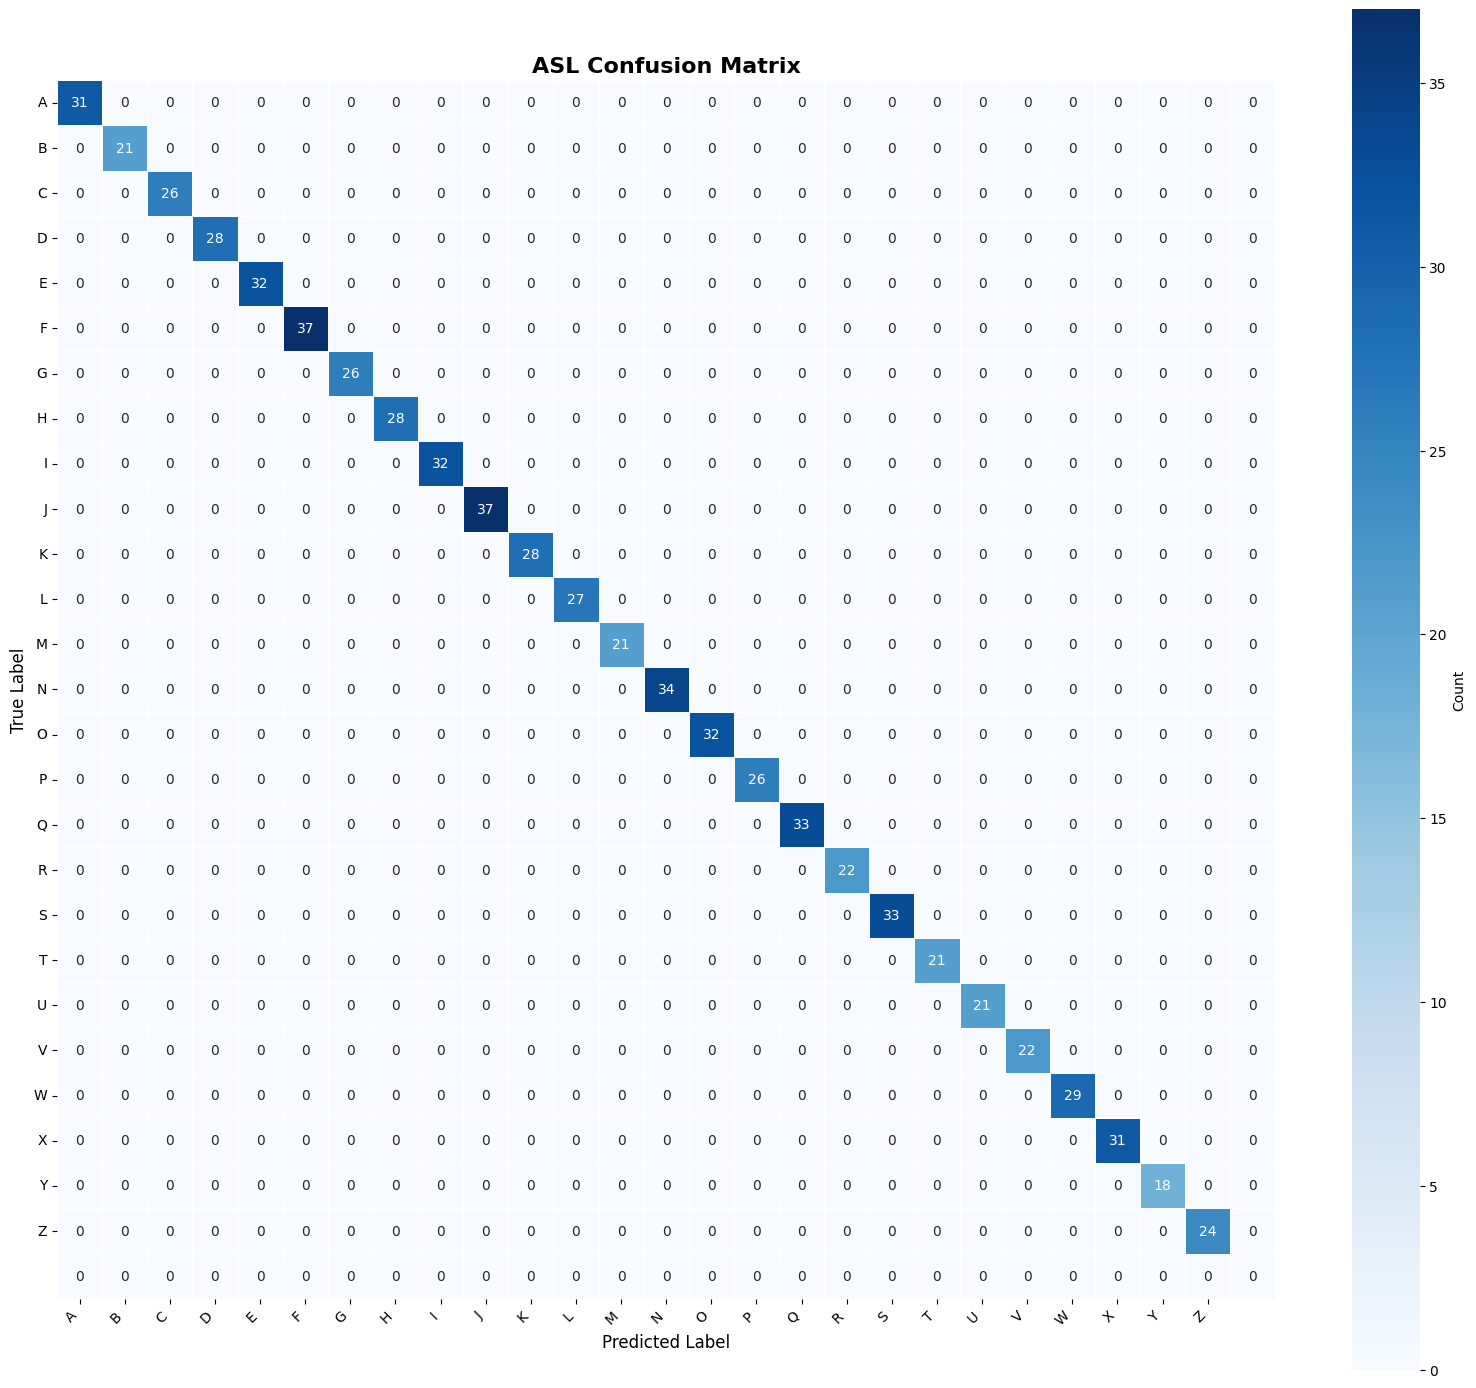

Overall Accuracy from Confusion Matrix: 1.0000
Running inference on test set...

image 1/715 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A0_jpg.rf.beea8a405220871911fb117e36526deb.jpg: 640x640 1 A, 1 O, 2.3ms
image 2/715 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A11_jpg.rf.bf055dc8a9a5a85bed0cc1f792c56a01.jpg: 640x640 1 A, 2.3ms
image 3/715 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A11_jpg.rf.ff2610c21c7f6d0a793cb58efc3bd96e.jpg: 640x640 1 A, 2.3ms
image 4/715 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A13_jpg.rf.4533aea9a6c32fecadcd1d1963e7dc78.jpg: 640x640 1 A, 2.3ms
image 5/715 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A13_jpg.rf.ae43f794ac52ed83c47f4df799a3504e.jpg: 640x640 1 A, 2.3ms
image 6/715 /home/kjasman

In [32]:
def plot_custom_confusion_matrix(val_results, model):
    """Plot custom confusion matrix from validation results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get confusion matrix and class names
    conf_matrix = np.array(val_results.confusion_matrix.matrix)
    class_names = list(model.names.values())
    
    # Determine if normalized or count data
    is_normalized = conf_matrix.max() <= 1.0
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    if is_normalized:
        sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Normalized Frequency'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix (Normalized)'
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Count'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix'
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    if is_normalized:
        accuracy = np.trace(conf_matrix) / len(conf_matrix)
    else:
        total_samples = np.sum(conf_matrix)
        correct_predictions = np.trace(conf_matrix)
        accuracy = correct_predictions / total_samples
        print(f"Overall Accuracy from Confusion Matrix: {accuracy:.4f}")

def validate_model(model, yaml_config_path):
    """Validate the trained model."""
    print("Running validation...")

    # Validate on validation set
    val_results = model.val(
        data=yaml_config_path,
        save=False,          # Don't save prediction images
        save_json=False,     # Don't save JSON results
        save_txt=False,      # Don't save txt results
        plots=True          # Don't save automatic plots
    )

    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    
    # Plot custom confusion matrix
    print("\nGenerating custom confusion matrix...")
    plot_custom_confusion_matrix(val_results, model)

    return val_results

def test_model(model, test_images_path):
    """Test the model on test set."""
    print("Running inference on test set...")

    test_results = model.predict(
        source=test_images_path,
        save=True,
        project='yolo_testing',
        name='test_results',
        exist_ok=True,     
        conf=0.25,
        iou=0.45
    )

    return test_results

# Validate the model
validation_results = validate_model(model, yaml_config_path)

# Test on test set
test_images_path = os.path.join(OUTPUT_PATH, 'test', 'images')
test_results = test_model(model, test_images_path)

In [33]:
def plot_training_results():
    """Plot training metrics from the results with column names."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        # Load results
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()  # Remove any whitespace
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Box Loss
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
        axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange')
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Classification Loss
        axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='blue')
        axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. mAP Metrics
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='red')
        axes[1, 0].set_title('mAP Metrics')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 4. Precision and Recall
        axes[1, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='purple')
        axes[1, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='brown')
        axes[1, 1].set_title('Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()
        
        # Print final metrics
        final_epoch = df.iloc[-1]
        print("\n" + "="*50)
        print("FINAL TRAINING METRICS (Epoch 100)")
        print("="*50)
        print(f"📊 Training Losses:")
        print(f"   Box Loss: {final_epoch['train/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['train/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['train/dfl_loss']:.4f}")
        print(f"\n📊 Validation Losses:")
        print(f"   Box Loss: {final_epoch['val/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['val/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['val/dfl_loss']:.4f}")
        print(f"\n🎯 Performance Metrics:")
        print(f"   Precision: {final_epoch['metrics/precision(B)']:.4f}")
        print(f"   Recall: {final_epoch['metrics/recall(B)']:.4f}")
        print(f"   mAP@0.5: {final_epoch['metrics/mAP50(B)']:.4f}")
        print(f"   mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f}")
        
    else:
        print("Training results not found. Check the training output directory.")

def plot_additional_metrics():
    """Plot additional training metrics like DFL loss and learning rates."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # 1. DFL Loss (Distribution Focal Loss)
        axes[0].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', color='blue')
        axes[0].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', color='orange')
        axes[0].set_title('Distribution Focal Loss (DFL)')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('DFL Loss')
        axes[0].legend()
        axes[0].grid(True)

        # 2. Learning Rate Schedule
        axes[1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate', color='red')
        axes[1].set_title('Learning Rate Schedule')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Learning Rate')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_yscale('log')  # Log scale for better visualization

        plt.tight_layout()
        plt.show()
    else:
        print("Training results not found.")

# Run the corrected plotting functions
plot_training_results()
plot_additional_metrics()



Training results not found. Check the training output directory.
Training results not found.


Testing prediction on: yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg

image 1/1 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg: 640x640 1 E, 2.1ms
Speed: 1.2ms preprocess, 2.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


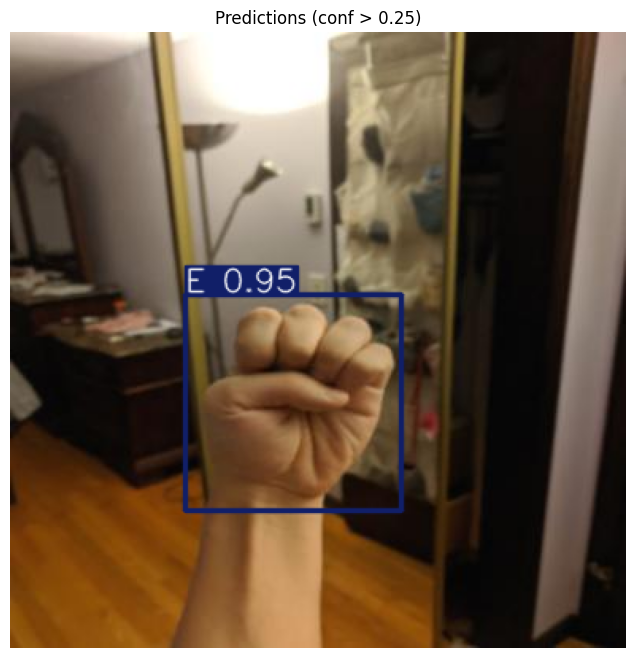

Detection 1: E (confidence: 0.949)


In [34]:
def predict_single_image(model, image_path, conf_threshold=0.25):
    """Make prediction on a single image."""
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        show=False
    )

    # Display results
    for r in results:
        # Plot results
        im_array = r.plot()
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Predictions (conf > {conf_threshold})')
        plt.show()

        # Print detection info
        if len(r.boxes) > 0:
            for i, box in enumerate(r.boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"Class_{class_id}"
                print(f"Detection {i+1}: {class_name} (confidence: {confidence:.3f})")
        else:
            print("No detections found")

# Test prediction on a sample image
test_images = os.listdir(os.path.join(OUTPUT_PATH, 'test', 'images'))
if test_images:
    sample_image = os.path.join(OUTPUT_PATH, 'test', 'images', test_images[0])
    print(f"Testing prediction on: {sample_image}")
    predict_single_image(model, sample_image)

In [35]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Original dataset: /data/YOLO-Bulk")
print(f"Dataset split: {OUTPUT_PATH}")
print(f"Class names loaded from: /data/YOLO-Bulk/data.yaml")
print(f"Model trained for {EPOCHS} epochs")

# Trained model yolo_training/custom_model/weights/best.pt
# Original Dataset: /data/YOLO-Bulk

TRAINING SUMMARY
Original dataset: /data/YOLO-Bulk
Dataset split: yolo_dataset_split
Class names loaded from: /data/YOLO-Bulk/data.yaml
Model trained for 500 epochs
